<a href="https://colab.research.google.com/github/vikasg964/Creditcard_frauddetection-using-CNN-NN-XGBoost/blob/main/Creditcard_fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

helper Functions

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/My Drive/AI/creditcard.csv")

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Detecting Null Values

In [6]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
data.shape

(284807, 31)

In [8]:
data.describe

<bound method NDFrame.describe of             Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]>

In [9]:
data.count()

Time      284807
V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
V6        284807
V7        284807
V8        284807
V9        284807
V10       284807
V11       284807
V12       284807
V13       284807
V14       284807
V15       284807
V16       284807
V17       284807
V18       284807
V19       284807
V20       284807
V21       284807
V22       284807
V23       284807
V24       284807
V25       284807
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Normal and Fraud Dataset

In [11]:
Fraud = data[data['Class']==1]
Normal = data[data['Class']==0]

In [12]:
pd.concat([Normal.Amount.describe(), Normal.Time.describe()],  axis=1)

,Amount,Time
count,284315.000000,284315.000000
mean,88.291022,94838.202258
std,250.105092,47484.015786
min,0.000000,0.000000
25%,5.650000,54230.000000
50%,22.000000,84711.000000
75%,77.050000,139333.000000
max,25691.160000,172792.000000


In [13]:
pd.concat([Fraud.Amount.describe(), Fraud.Time.describe()],  axis=1)

,Amount,Time
count,492.000000,492.000000
mean,122.211321,80746.806911
std,256.683288,47835.365138
min,0.000000,406.000000
25%,1.000000,41241.500000
50%,9.250000,75568.500000
75%,105.890000,128483.000000
max,2125.870000,170348.000000


In [14]:
print('Fraud Shape:\t', Fraud.shape)
print('Normal Shape:\t', Normal.shape)

Fraud Shape:	 (492, 31)
Normal Shape:	 (284315, 31)


In [17]:
pd.concat([Fraud.Time.describe(), Normal.Time.describe()], axis=1)


,Time,Time
count,492.000000,284315.000000
mean,80746.806911,94838.202258
std,47835.365138,47484.015786
min,406.000000,0.000000
25%,41241.500000,54230.000000
50%,75568.500000,84711.000000
75%,128483.000000,139333.000000
max,170348.000000,172792.000000


Graph for fradulent and Non fradulent

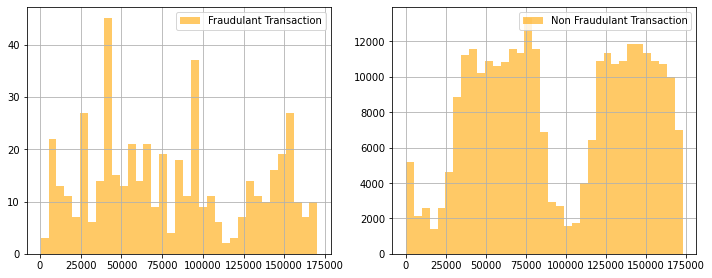

In [19]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='orange', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='orange', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

Split the data into X and Y

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X = data.drop('Class', axis=1)
y = data.Class

In [44]:
y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [46]:
# Applying StandardScalar preprocessing on the x data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-1.99658302, -0.69424232, -0.04407492, ...,  0.33089162,
        -0.06378115,  0.24496426],
       [-1.99658302,  0.60849633,  0.16117592, ..., -0.02225568,
         0.04460752, -0.34247454],
       [-1.99656197, -0.69350046, -0.81157783, ..., -0.13713686,
        -0.18102083,  1.16068593],
       ...,
       [ 1.6419735 ,  0.98002374, -0.18243372, ...,  0.01103672,
        -0.0804672 , -0.0818393 ],
       [ 1.6419735 , -0.12275539,  0.32125034, ...,  0.26960398,
         0.31668678, -0.31324853],
       [ 1.64205773, -0.27233093, -0.11489898, ..., -0.00598394,
         0.04134999,  0.51435531]])

Downsampling with near miss

In [47]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Counter({0: 284315, 1: 492})


In [48]:
# Applying NearMiss downsampling technique for imbalanced data
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X, y = nr.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
Counter(y)

Counter({0: 492, 1: 492})

Split train and test

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
# Accuracy
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set:',lr.score(X_test, y_test))

Accuracy of logistic regression classifier on test set: 0.9441624365482234


[[90  1]
 [10 96]]


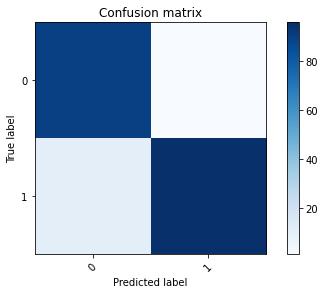

In [56]:
# Print and plot confusion matrix   
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

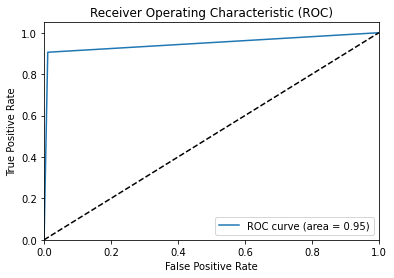

In [57]:
# Plot roc curve
plot_roc(y_pred,y_test)

In [58]:
# Print Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94        91
           1       0.99      0.91      0.95       106

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



CNN

In [59]:
X_traincnn = np.expand_dims(X_train,axis=2)
X_testcnn = np.expand_dims(X_test, axis=2)

In [60]:
X_traincnn.shape

(787, 30, 1)

In [61]:
X_testcnn.shape

(197, 30, 1)

In [65]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(30,1), activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#use_bias=True in dense layer
model.add(Dense(100, activation='relu', use_bias=True))
model.add(Dense(2, activation='softmax', use_bias=True))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".best_weights.hdf5", verbose=0, save_best_only=True)
model.fit(X_traincnn, y_train,validation_data=(X_testcnn,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('.best_weights.hdf5')

model.summary()

Epoch 1/200
25/25 - 0s - loss: 0.3261 - accuracy: 0.8526 - val_loss: 0.3510 - val_accuracy: 0.8934
Epoch 2/200
25/25 - 0s - loss: 0.2132 - accuracy: 0.9403 - val_loss: 0.1755 - val_accuracy: 0.9239
Epoch 3/200
25/25 - 0s - loss: 0.1621 - accuracy: 0.9504 - val_loss: 0.1371 - val_accuracy: 0.9543
Epoch 4/200
25/25 - 0s - loss: 0.1310 - accuracy: 0.9619 - val_loss: 0.1307 - val_accuracy: 0.9391
Epoch 5/200
25/25 - 0s - loss: 0.1188 - accuracy: 0.9670 - val_loss: 0.1278 - val_accuracy: 0.9492
Epoch 6/200
25/25 - 0s - loss: 0.1303 - accuracy: 0.9593 - val_loss: 0.1591 - val_accuracy: 0.9391
Epoch 7/200
25/25 - 0s - loss: 0.1061 - accuracy: 0.9657 - val_loss: 0.1091 - val_accuracy: 0.9695
Epoch 8/200
25/25 - 0s - loss: 0.0972 - accuracy: 0.9682 - val_loss: 0.0878 - val_accuracy: 0.9695
Epoch 9/200
25/25 - 0s - loss: 0.0975 - accuracy: 0.9746 - val_loss: 0.0952 - val_accuracy: 0.9746
Epoch 10/200
25/25 - 0s - loss: 0.0898 - accuracy: 0.9733 - val_loss: 0.1049 - val_accuracy: 0.9746
Epoch 11/

Neural Networks

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=2, mode='min')

chckpt = ModelCheckpoint(filepath='.weights.hdf5', verbose=1, save_best_only=True)

model.fit(X_train,y_train,verbose=2,epochs=200, batch_size=20, 
          callbacks=[monitor, chckpt], validation_split=0.25)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.24586, saving model to .weights.hdf5
30/30 - 0s - loss: 0.4064 - accuracy: 0.8627 - val_loss: 0.2459 - val_accuracy: 0.9543
Epoch 2/200

Epoch 00002: val_loss improved from 0.24586 to 0.17072, saving model to .weights.hdf5
30/30 - 0s - loss: 0.2484 - accuracy: 0.9424 - val_loss: 0.1707 - val_accuracy: 0.9594
Epoch 3/200

Epoch 00003: val_loss improved from 0.17072 to 0.12802, saving model to .weights.hdf5
30/30 - 0s - loss: 0.1801 - accuracy: 0.9492 - val_loss: 0.1280 - val_accuracy: 0.9746
Epoch 4/200

Epoch 00004: val_loss improved from 0.12802 to 0.11297, saving model to .weights.hdf5
30/30 - 0s - loss: 0.1497 - accuracy: 0.9576 - val_loss: 0.1130 - val_accuracy: 0.9645
Epoch 5/200

Epoch 00005: val_loss improved from 0.11297 to 0.11278, saving model to .weights.hdf5
30/30 - 0s - loss: 0.1372 - accuracy: 0.9576 - val_loss: 0.1128 - val_accuracy: 0.9695
Epoch 6/200

Epoch 00006: val_loss improved from 0.11278 to 0.09289, savin

In [69]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4dde6f3208>>

In [70]:
y_pred = model.predict(X_test)
y_pred


array([[3.7976503e-03],
       [1.0000000e+00],
       [1.0094941e-03],
       [1.0000000e+00],
       [9.9983126e-01],
       [2.2114217e-03],
       [6.1351061e-04],
       [9.9999648e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.4844537e-03],
       [9.9999928e-01],
       [4.6795309e-03],
       [1.7451316e-02],
       [9.9999976e-01],
       [9.1245770e-04],
       [9.9995178e-01],
       [9.9996316e-01],
       [4.5535266e-03],
       [3.2378554e-02],
       [2.5197327e-02],
       [1.0000000e+00],
       [3.9309040e-01],
       [9.7634017e-01],
       [1.2409985e-03],
       [8.2381690e-01],
       [6.8232715e-03],
       [9.3412399e-04],
       [9.9997818e-01],
       [1.0000000e+00],
       [1.8597528e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.8018057e-02],
       [4.4539571e-03],
       [1.3442934e-03],
       [1.2499481e-02],
       [1.0859370e-03],
       [6.2936544e-04],
       [1.1697114e-03],
       [9.999997

In [71]:
#from the y_pred, we will only be considering the one's greater than 0.5
argmax = []
for val in y_pred:
    if val >= 0.5:
      argmax.append(1)
    else:
        argmax.append(0)
argmax[:10]

[0, 1, 0, 1, 1, 0, 0, 1, 1, 1]

In [73]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,argmax)
print("Accuracy for neural network on test set:", accuracy)

Accuracy for neural network on test set: 0.9746192893401016


[[ 91   0]
 [  5 101]]


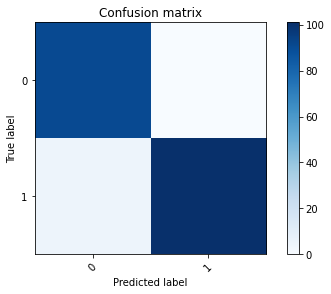

In [75]:
cm = confusion_matrix(y_test, argmax)
print(cm)
plot_confusion_matrix(cm,['0','1'])

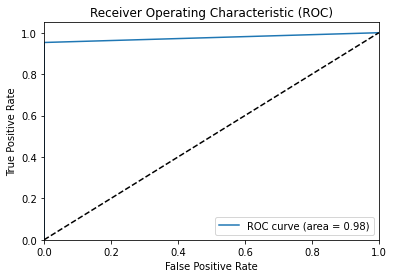

In [76]:
plot_roc(argmax,y_test)

XGBoost

In [77]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [78]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [79]:

print(xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [81]:
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [82]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy for XGBoost on test set:", accuracy)

Accuracy for XGBoost on test set: 0.9796954314720813


In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        91
           1       1.00      0.96      0.98       106

    accuracy                           0.98       197
   macro avg       0.98      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



[[ 91   0]
 [  4 102]]


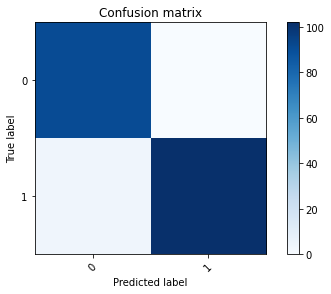

In [84]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

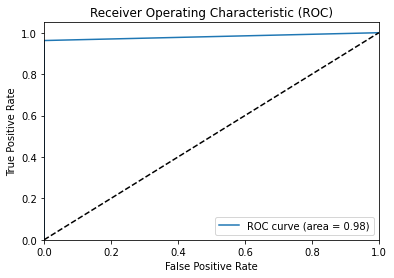

In [85]:

plot_roc(y_pred,y_test)